## Author: Ivan Polakovic
## Computer Vision Individual Assignment

### Agenda:
### 1.Load Libraries
### 2.Model Ensemble
### 3.XGBoost
### 4.Random Forest

### Load Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.svm import SVC
import warnings

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from skimage import filters
from skimage.draw import ellipse
from skimage.measure import label, regionprops, regionprops_table
from skimage.transform import rotate
import cv2

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be import

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Load the images and crop out area of interest.

I tried using the method regionprops (see appendix) but i ended up with a manual crop. Although this worked pretty well for this example, this would not be ideal to generalize in case the center of the images change around.


In [3]:
def prep_data (folder):
    # iterate through folders, assembling feature, label, and classname data objects
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    import cv2

    class_id = 0
    features = []
    labels = np.array([])
    classnames = []
    for root, dirs, filenames in os.walk(folder):
        for d in sorted(dirs):
            print("Reading data from", d)
            # use the folder name as the class name for this label
            classnames.append(d)
            files = os.listdir(os.path.join(root,d))
            for f in files:
                # Load the image file
                imgFile = os.path.join(root,d, f)
                img = plt.imread(imgFile)
                #img = cv2.imread(imgFile,cv2.IMREAD_GRAYSCALE)
                # Defining the size of the image we want to keep from the initial one
                height, width = img.shape[0:2]
                startRow = int(height*.15)
                startCol = int(width*.20)
                endRow = int(height*.96)
                endCol = int(width*.80)
                # Setting the boundaries we want for the cropped image
                croppedimg = img[startRow:endRow, startCol:endCol]
                # The image array is a multidimensional numpy array
                # - flatten it to a single array of pixel values for scikit-learn
                # - and add it to the list of features
                features.append(croppedimg.ravel())
                
                # Add it to the numpy array of labels
                labels = np.append(labels, class_id )
            class_id  += 1
            
    # Convert the list of features into a numpy array
    features = np.array(features)
    
    return features, labels, classnames


# The images are in a folder named 'shapes/training'
training_folder_name =  '/content/gdrive/My Drive/Term III/Computer Vision/ind_assignment/training'

# Prepare the image data
features, labels, classnames = prep_data(training_folder_name)
print(len(features), 'features')
print(len(labels), 'labels')
print(len(classnames), 'classes:', classnames)

Reading data from dead
Reading data from live
70 features
70 labels
2 classes: ['dead', 'live']


In [4]:
print('Feature Shape:',features.shape)
print('Labels Shape:',labels.shape)

Feature Shape: (70, 175557)
Labels Shape: (70,)


In [5]:
# split into training and testing sets
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.30)

print('Training records:',y_train.size)
print('Test records:',y_test.size)

Training records: 49
Test records: 21


In [ ]:

# Convert the training features to floats so they can be scaled
# no scaling needed here!
# x_train = x_train.astype('float64')
#from sklearn.preprocessing import MinMaxScaler
#trans = MinMaxScaler()

In [6]:
# check length of train and test
len(x_train[0])
# 696 * 520 before cropping
# 421 * 417 after cropping

175557

## Modelling > Ensemble

Out-of-Fold Predictions >> This ensembling uses predictions of base classifiers as input for training to a second-level model. 

I tried using the ensemble, but the second level model had the same results as the first, therefore I kept it to one XGBoost model

In [7]:
#from sklearn.model_selection import StratifiedKFold
ntrain = x_train.shape[0]
ntest = x_test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(n_splits=NFOLDS, shuffle=True, random_state=SEED)
#kf = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)

In [8]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [9]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

#Support Vector Classifier parameters 
svc_params = {
  'kernel' : 'linear',
  'C' : 0.025
}

In [10]:
# Create 5 objects that represent our 5 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [11]:
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

print("Training is complete")

Training is complete


In [12]:
x_train_concat = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test_concat = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

In [13]:
len(x_train_concat)

49

In [14]:
len(et_oof_train)

49

In [15]:
import xgboost as xgb
gbm = xgb.XGBClassifier(
    learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train_concat, y_train)
predictions = gbm.predict(x_test_concat)

In [16]:
predictions

array([0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
       0., 0., 0., 1.])

Classifier Metrics:
              precision    recall  f1-score   support

        dead       1.00      0.89      0.94         9
        live       0.92      1.00      0.96        12

    accuracy                           0.95        21
   macro avg       0.96      0.94      0.95        21
weighted avg       0.96      0.95      0.95        21

Accuracy: 95.24%

 Confusion Matrix:


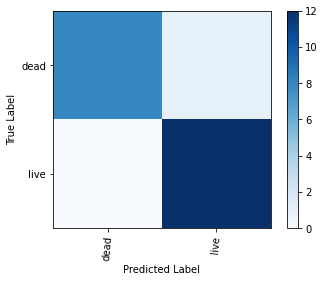

In [17]:
# Evaluate classifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Convert the test features for scaling
#x_test = x_test.astype('float64')

print('Classifier Metrics:')
#predictions = gbm.predict(x_test_concat)
print(metrics.classification_report(y_test, predictions, target_names=classnames))
print('Accuracy: {:.2%}'.format(metrics.accuracy_score(y_test, predictions)))

print("\n Confusion Matrix:")
cm = confusion_matrix(y_test, np.round(predictions, 0))
# Plot confusion matrix as heatmap
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Due to feature mismatch, the ensemble model was not able to be used therefore we try directly with XGBoost

In [30]:
import xgboost as xgb
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)  # here we changed the output of all the models to just the x_train and y_train
predictions = gbm.predict(x_test)

In [31]:
predictions

array([0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
       0., 0., 0., 1.])

Classifier Metrics:
              precision    recall  f1-score   support

        dead       1.00      0.89      0.94         9
        live       0.92      1.00      0.96        12

    accuracy                           0.95        21
   macro avg       0.96      0.94      0.95        21
weighted avg       0.96      0.95      0.95        21

Accuracy: 95.24%

 Confusion Matrix:


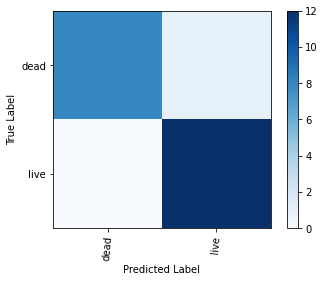

In [32]:
print('Classifier Metrics:')
#predictions = gbm.predict(x_test_concat)
print(metrics.classification_report(y_test, predictions, target_names=classnames))
print('Accuracy: {:.2%}'.format(metrics.accuracy_score(y_test, predictions)))

print("\n Confusion Matrix:")
cm = confusion_matrix(y_test, np.round(predictions, 0))
# Plot confusion matrix as heatmap
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


Grab the test images and classify them

In [33]:
# Save the trained model
import sys
import os
import pickle

print ("Exporting the model")
file_stream = open('shape_classifier.pkl', 'wb')
pickle.dump(gbm, file_stream)
file_stream.close()

Exporting the model


In [34]:
# Helper function to resize image
def resize_image(src_img, size=(), bg_color="white"): 
    from PIL import Image
    # 696 520
    # rescale the image so the longest edge is the right size
    src_img.thumbnail(size, Image.ANTIALIAS)
    
    # Create a new image of the right shape
    new_image = Image.new("RGB", size, bg_color)
    
    # Paste the rescaled image onto the new background
    new_image.paste(src_img, (int((size[0] - src_img.size[0]) / 2), int((size[1] - src_img.size[1]) / 2)))
    
    # return the resized image
    return new_image

# Function to predict the class of an image
def predict_image(classifier, image_array):
    import numpy as np
    
    # These are the classes our model can predict
    classnames = ['dead', 'live']
    
    # Predict the class of each input image
    predictions = classifier.predict(image_array)
    
    predicted_classes = []
    for prediction in predictions:
        # And append the corresponding class name to the results
        predicted_classes.append(classnames[int(prediction)])
    # Return the predictions
    return predicted_classes

print("Functions created - ready to use model for inference.")

Functions created - ready to use model for inference.


## Import Test Images

## I tried to split the code and analyse line by line

In [20]:
# I am going to go line by line and document what they do to see if i understand what is this doing :)

In [35]:
import os
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline

# Load the model
print("Importing the model")
file_stream = open('shape_classifier.pkl', 'rb')   # <_io.BufferedReader name='shape_classifier.pkl'> >>> opened a file, dumped the gbm model
clf = pickle.load(file_stream)   # classifier I used with all the hyperparameters
file_stream.close()  # why are we closing the file?

Importing the model


In [36]:
#get the list of test image files
test_folder = '/content/gdrive/My Drive/Term III/Computer Vision/ind_assignment/test'
test_image_files = os.listdir(test_folder)  #name of every image (30) on this directory


In [37]:
# Empty array on which to store the images
image_arrays = []

size = (696,520) # i changed the size here
background_color = "white"  #not sure what this is for

fig = plt.figure(figsize=(20, 20)) # not sure either, this might be matplotlib "aes" where the results will be displayed

<Figure size 1440x1440 with 0 Axes>

In [38]:
# Get the images and show the predicted classes
for file_idx in range(len(test_image_files)):
    #img = Image.open(os.path.join(test_folder, test_image_files[file_idx])) #why image.open if we are using something different on the top?

    imgFile = os.path.join(test_folder, test_image_files[file_idx])
    #img = plt.imread(imgFile,cv2.IMREAD_GRAYSCALE)
    img = cv2.imread(imgFile,cv2.IMREAD_GRAYSCALE)


    #img = plt.imread(imgFile)
    #img = cv2.imread(imgFile,cv2.IMREAD_GRAYSCALE)
    # Defining the size of the image we want to keep from the initial one
    height, width = img.shape[0:2]
    startRow = int(height*.15)
    startCol = int(width*.20)
    endRow = int(height*.96)
    endCol = int(width*.80)
    # Setting the boundaries we want for the cropped image
    croppedimg = img[startRow:endRow, startCol:endCol]

    img_shape = np.array(croppedimg).shape
                      
    # Add the image to the array of images
    image_arrays.append(croppedimg.ravel())

In [39]:

len(np.array(image_arrays)[0]) # same size as training

175557

In [40]:
img_shape

(421, 417)

In [41]:
len(image_arrays) # making sure there are only 30 images to classify

30

In [42]:
gbm

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.9,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=2, missing=None, n_estimators=2000, n_jobs=1,
              nthread=-1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

In [43]:
# Get predictions from the array of image arrays
# Note that the model expects an array of 1 or more images - just like the batches on which it was trained
predictions = predict_image(clf, np.array(image_arrays))



Results XGBoost

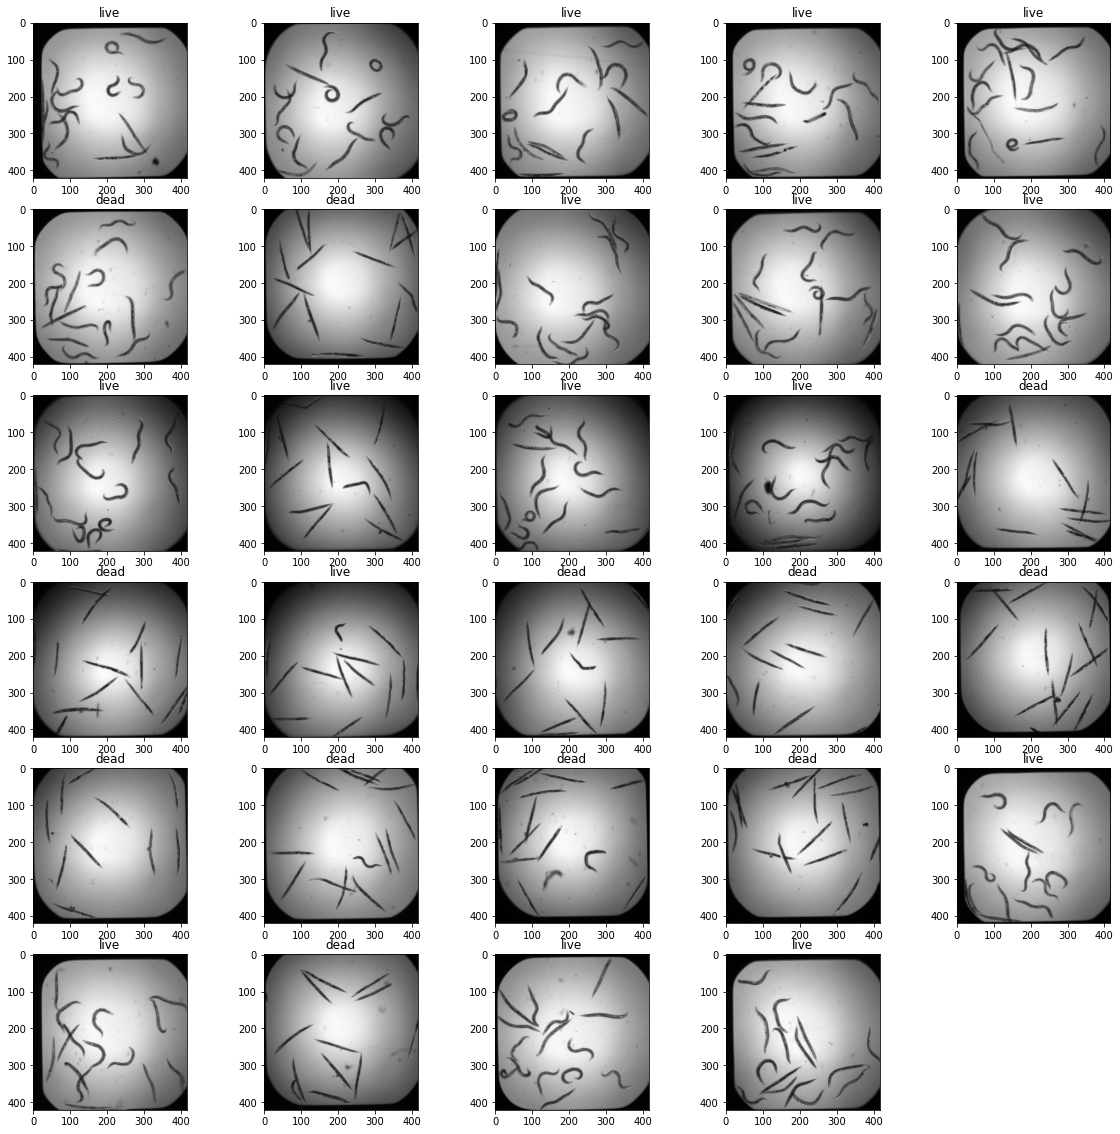

In [44]:
w=20
h=20
fig=plt.figure(figsize=(20, 20))
columns = 5
rows = 6
for i in range(1, 30):
    img = image_arrays[i].reshape(img_shape)
    fig.add_subplot(rows, columns, i)
    plt.title(predictions[i])
    plt.rc('image', cmap='gray')
    plt.imshow(img)
plt.show()

XGBoost can tend to overfit and unfortunately we were no able to implement the ensemble model that would help with that issue.

Therefore we will run a Random Forest with randomized search and compare results

In [45]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
from pprint import pprint

In [46]:
print('Parameters currently in use:\n')
pprint(rfc.get_params())


Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [ ]:
## most relevant hyperparameters for random forest
#n_estimators = number of trees in the foreset
#max_features = max number of features considered for splitting a node
#max_depth = max number of levels in each decision tree
#min_samples_split = min number of data points placed in a node before the node is split
#min_samples_leaf = min number of data points allowed in a leaf node
#bootstrap = method for sampling data points (with or without replacement)

In [47]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 7,10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
random_state = [int(x) for x in np.linspace(1, 500, num = 10)]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'criterion':['entropy','gini'],
               'random_state':42,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'random_state':random_state}
pprint(random_grid)

{'bootstrap': [True, False],
 'criterion': ['entropy', 'gini'],
 'max_depth': [10, 21, 32, 43, 54, 65, 76, 87, 98, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 7, 10],
 'n_estimators': [200, 288, 377, 466, 555, 644, 733, 822, 911, 1000],
 'random_state': [1, 56, 111, 167, 222, 278, 333, 389, 444, 500]}


In [50]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
#rfc = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, n_jobs = -1)
# Fit the random search model
rfc_random.fit(x_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   59.6s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  7.5min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [51]:
rfc_random.best_params_

{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': 21,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 7,
 'n_estimators': 377,
 'random_state': 389}

In [53]:
rfc = RandomForestClassifier(random_state= 389,
 n_estimators= 377,
 min_samples_split= 7,
 min_samples_leaf= 1,
 max_features= 'sqrt',
 max_depth= 21,
 criterion= 'gini',
 bootstrap= False)
rfc.fit(x_train, y_train)
rfc_prediction = rfc.predict(x_test)

In [55]:
len(rfc_prediction)

21

Classifier Metrics:
              precision    recall  f1-score   support

        dead       1.00      0.78      0.88         9
        live       0.86      1.00      0.92        12

    accuracy                           0.90        21
   macro avg       0.93      0.89      0.90        21
weighted avg       0.92      0.90      0.90        21

Accuracy: 90.48%

 Confusion Matrix:


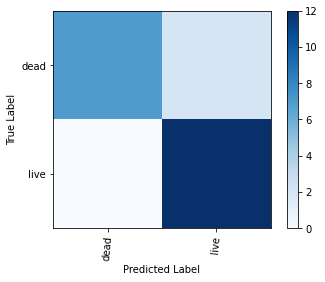

In [56]:
print('Classifier Metrics:')
#predictions = gbm.predict(x_test_concat)
print(metrics.classification_report(y_test, rfc_prediction, target_names=classnames))
print('Accuracy: {:.2%}'.format(metrics.accuracy_score(y_test, rfc_prediction)))

print("\n Confusion Matrix:")
cm = confusion_matrix(y_test, np.round(rfc_prediction, 0))
# Plot confusion matrix as heatmap
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [57]:
# Get predictions from the array of image arrays
# Note that the model expects an array of 1 or more images - just like the batches on which it was trained
predictions = predict_image(rfc, np.array(image_arrays))

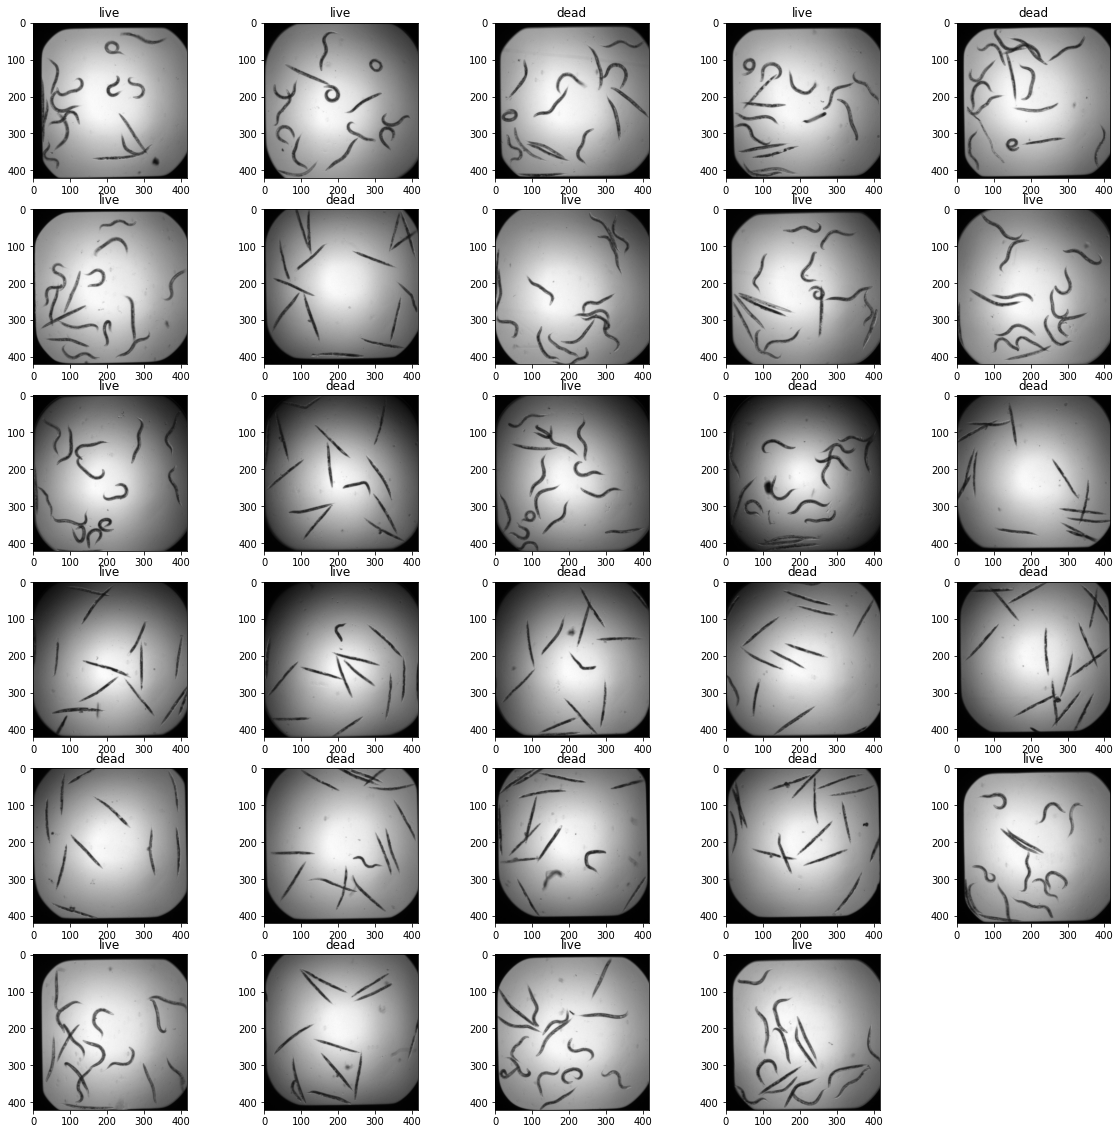

In [58]:
w=20
h=20
fig=plt.figure(figsize=(20, 20))
columns = 5
rows = 6
for i in range(1, 30):
    img = image_arrays[i].reshape(img_shape)
    fig.add_subplot(rows, columns, i)
    plt.title(predictions[i])
    plt.rc('image', cmap='gray')
    plt.imshow(img)
plt.show()

Very interestingly we see both models (XGBoost vs RF) performing pretty well, although it seems RF has been more accurate in generalising with the test images. This could be due to XGBoost tending to overfit


Still, we can observe as an example, that in the fourth row all images are clearly dead worms and XGBoost misclassified only one image while RF did two.

Appendix

In [ ]:
from skimage import filters
imgFile='/content/gdrive/My Drive/Term III/Computer Vision/ind_assignment/training/live/1649_1109_0003_Amp5-1_B_20070424_A01_w2_15ADF48D-C09E-47DE-B763-5BC479534681.jpg'
image = plt.imread(imgFile)
#image = np.mean(imageRGB, axis=0)
val = filters.threshold_otsu(image)
image=image<val
label_img = label(image)
regions = regionprops(label_img)

In [ ]:
import math
fig, ax = plt.subplots()
ax.imshow(image, cmap=plt.cm.gray)

for props in regions:
    y0, x0 = props.centroid
    orientation = props.orientation
    x1 = x0 + math.cos(orientation) * 0.5 * props.minor_axis_length
    y1 = y0 - math.sin(orientation) * 0.5 * props.minor_axis_length
    x2 = x0 - math.sin(orientation) * 0.5 * props.major_axis_length
    y2 = y0 - math.cos(orientation) * 0.5 * props.major_axis_length

    ax.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
    ax.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
    ax.plot(x0, y0, '.g', markersize=15)

    minr, minc, maxr, maxc = props.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    ax.plot(bx, by, '-b', linewidth=2.5)

ax.axis((0, 600, 600, 0))
plt.show()